In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import pi, sqrt

DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training_set')
TEST_DIR = os.path.join(DATA_DIR, 'test_set')

In [2]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'training_set_pixel_size_and_HC.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_set_pixel_size.csv'))

print(f"Training: {len(train_df)} samples")
print(f"Test: {len(test_df)} samples")
train_df.head()

Training: 999 samples
Test: 335 samples


,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


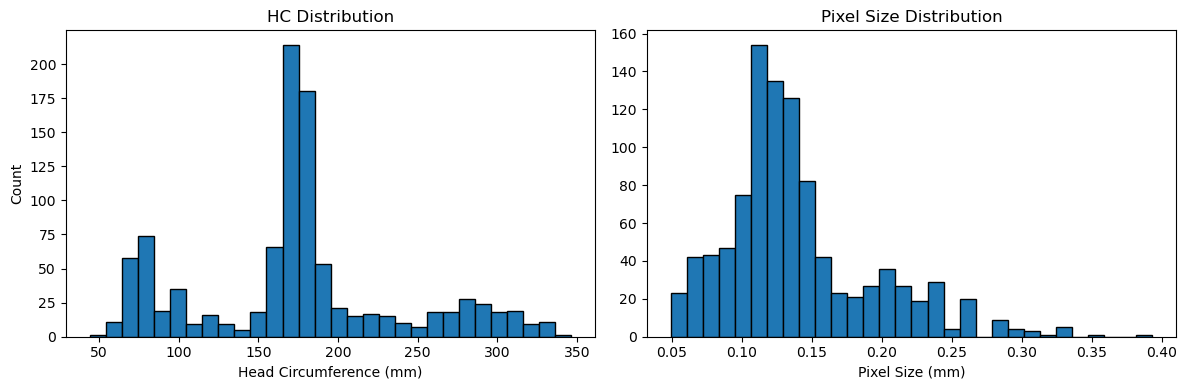

count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: head circumference (mm), dtype: float64


In [3]:
# HC distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(train_df['head circumference (mm)'], bins=30, edgecolor='black')
ax[0].set_xlabel('Head Circumference (mm)')
ax[0].set_ylabel('Count')
ax[0].set_title('HC Distribution')

ax[1].hist(train_df['pixel size(mm)'], bins=30, edgecolor='black')
ax[1].set_xlabel('Pixel Size (mm)')
ax[1].set_title('Pixel Size Distribution')

plt.tight_layout()
plt.savefig('figures/HC_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

print(train_df['head circumference (mm)'].describe())

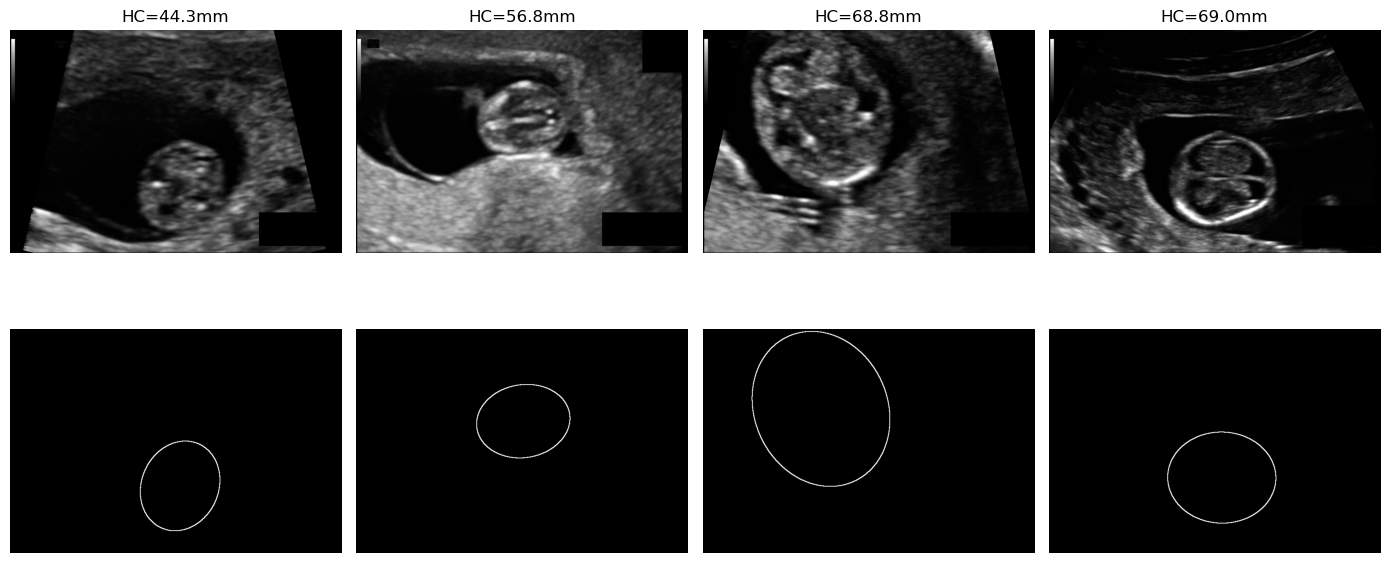

In [4]:
# sample images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i in range(4):
    fname = train_df['filename'].iloc[i]
    img = cv2.imread(os.path.join(TRAIN_DIR, fname), 0)
    annot = cv2.imread(os.path.join(TRAIN_DIR, fname.replace('.png', '_Annotation.png')), 0)
    hc = train_df.iloc[i]['head circumference (mm)']
    
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'HC={hc:.1f}mm')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(annot, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('figures/sample_images.pdf', dpi=150, bbox_inches='tight')
plt.show()

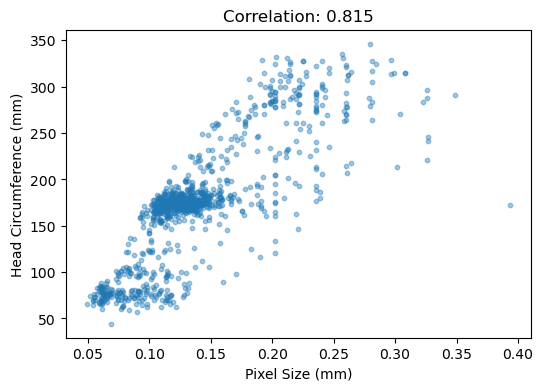

In [5]:
# pixel size vs HC correlation
plt.figure(figsize=(6, 4))
plt.scatter(train_df['pixel size(mm)'], train_df['head circumference (mm)'], alpha=0.4, s=10)
plt.xlabel('Pixel Size (mm)')
plt.ylabel('Head Circumference (mm)')
plt.title(f"Correlation: {train_df['pixel size(mm)'].corr(train_df['head circumference (mm)']):.3f}")
plt.savefig('figures/HC_corr.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
def ellipse_circumference(a, b):
    # Ramanujan approximation
    h = ((a - b) ** 2) / ((a + b) ** 2)
    return pi * (a + b) * (1 + (3 * h) / (10 + sqrt(4 - 3 * h)))

def get_ellipse(annot_img):
    _, binary = cv2.threshold(annot_img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    return cv2.fitEllipse(cnt)

def measure_hc(annot_path, pixel_size):
    annot = cv2.imread(annot_path, 0)
    if annot is None:
        return None
    ellipse = get_ellipse(annot)
    if ellipse is None:
        return None
    (cx, cy), (w, h), angle = ellipse
    a, b = max(w, h) / 2, min(w, h) / 2
    return ellipse_circumference(a, b) * pixel_size

In [7]:
results = []
for i, row in train_df.iterrows():
    annot_path = os.path.join(TRAIN_DIR, row['filename'].replace('.png', '_Annotation.png'))
    pred = measure_hc(annot_path, row['pixel size(mm)'])
    true = row['head circumference (mm)']
    if pred is not None:
        results.append({'file': row['filename'], 'true': true, 'pred': pred, 'error': abs(true - pred)})

results_df = pd.DataFrame(results)
mae = results_df['error'].mean()
print(f"MAE: {mae:.4f} mm")

MAE: 0.7135 mm
